In [79]:
import numpy as np
from numpy import linalg as LA
import time as t
import matplotlib.pyplot as plt
plt.tight_layout()

def randomGaussianArray(length, mu, sigma):
    return np.random.normal(mu, sigma, length)

def randomUniformArray(length, minimum, maximum):
    return np.random.uniform(minimum, maximum,length)

def getBit(intState,i):
    return (intState >> i) & 1

def flipIJ(intState, i, j):
    iBit = getBit(intState,i)
    jBit = getBit(intState,j)
    x = iBit ^ jBit
    x = (x << i) | (x << j)
    return x ^ intState

def binaryStateToIntegerState(binString): 
    return int(binString,2)

def integerStateToBinaryState(intState,length):
    return bin(intState)[2:].zfill(length)

def allowedIntegerStates(length, numParticles): 
    allowedStateSet = []
    startState = 2**numParticles - 1
    allowedStateSet.append(startState)
    endState = startState << (length - numParticles)
    
    iteratorState = startState
    leadingBitPosition = numParticles - 1
    trailingBitPosition = 0

    while(not(iteratorState == endState)):
        if numParticles == 1:
            if (iteratorState >> leadingBitPosition + 1) & 1:
                numParticles += 1
                leadingBitPosition += 1
                continue
            iteratorState = flipIJ(iteratorState, leadingBitPosition, leadingBitPosition + 1)
            leadingBitPosition += 1
            trailingBitPosition += 1
            allowedStateSet.append(iteratorState)
            continue

        if (iteratorState >> leadingBitPosition + 1) & 1:
            numParticles += 1
            leadingBitPosition += 1
            continue

        iteratorState = flipIJ(iteratorState, leadingBitPosition, leadingBitPosition + 1)
        for i in range(leadingBitPosition+1):
            if i<(numParticles-1):
                iteratorState = iteratorState | (1 << i)
            else:
                helper = ((iteratorState >> i) & 1)
                iteratorState = iteratorState ^ (helper << i)

        allowedStateSet.append(iteratorState)
        leadingBitPosition = numParticles - 2
        trailingBitPosition = 0
        numParticles -= 1
    
    return allowedStateSet
    
#conserved up spins (numParticles)
class SpinHalfChainFixed:
    def __init__(self, length, numParticles):
        
        self.length = length
        self.numParticles = numParticles
        self.allowedIntStateBasis = allowedIntegerStates(length,numParticles)
        self.basisDimension = len(self.allowedIntStateBasis)
        
        self.bitFlags = [0]*length
        for i in range(length): 
            self.bitFlags[i] = 2**i
        
        self.allowedStateIndexDictionary = []
        self.initalizeStateIndexDictionary()
        
        self.precomputeSpinZExpectationValues()
        self.createM1()
        
        
    def initalizeStateIndexDictionary(self):
        self.allowedStateIndexDictionary = [self.basisDimension] * (2**self.length)
        i = 0
        for a in self.allowedIntStateBasis:
            self.allowedStateIndexDictionary[a] = i
            i = i+1
    
    def precomputeSpinZExpectationValues(self):
        self.spinZExpectationValues = -0.5*np.ones((self.length,self.basisDimension))
        for i in range(self.length):
            for j in range(self.basisDimension):
                if getBit(self.allowedIntStateBasis[j],i): 
                    self.spinZExpectationValues[i,j] = .5
    
    def createM1(self):
        periodicPosition = np.exp(2j * np.pi * np.arange(self.length) / self.length)
        self.M1 = np.dot(np.transpose(self.spinZExpectationValues),periodicPosition)
    
    def createHeisenbergBaseHamiltonian(self, J):
        dim = self.basisDimension
        allowedStates = self.allowedIntStateBasis
        length = self.length
        dictionary = self.allowedStateIndexDictionary
        
        ham = np.zeros((dim,dim))
        indA = 0
        for a in allowedStates:
            for i in range(0, length-1):
                j = (i+1)
                
                iBit = getBit(a,i)
                jBit = getBit(a,j)
                
                if iBit == jBit:
                    ham[indA,indA] += (J * 0.25)
                else: 
                    ham[indA,indA] -= (J * 0.25)
                    b = flipIJ(a,i,j)
                    indB = dictionary[b]
                    ham[indA,indB] += (J * 0.25)
                    ham[indB,indA] += (J * 0.25)
            indA += 1
        return ham

    def HeisenbergDisorderInstance(self,h): 
        dim = self.basisDimension
        allowedStates = self.allowedIntStateBasis
        length = self.length
        zExpec = self.spinZExpectationValues
    
        wi = randomUniformArray(length, -h, h)
        dis = np.zeros((dim,dim))
        
        indA = 0
        for a in allowedStates:
            binStateList = zExpec[:,indA]
            dis[indA,indA] += np.dot(binStateList,wi)
            indA += 1
        return dis
    
    def specificHeisenbergDisorderInstance(self,harray): 
        dim = self.basisDimension
        allowedStates = self.allowedIntStateBasis
        length = self.length
        zExpec = self.spinZExpectationValues
    
        wi = harray
        dis = np.zeros((dim,dim))
        
        indA = 0
        for a in allowedStates:
            binStateList = zExpec[:,indA]
            dis[indA,indA] += np.dot(binStateList,wi)
            indA += 1
        return dis
    
    
    def CorrFunct(self, nsq, site1, site2):
        S1 = self.spinZExpectationValues[site1,:]
        S2 = self.spinZExpectationValues[site2,:]
        return np.dot(np.multiply(S1,S2),nsq) - np.dot(S1,nsq)*np.dot(S2,nsq)
    
    
def figure2(Lvals,hvals,dvals):
    Fvals = np.zeros((len(Lvals),len(hvals)))
    for i in range(len(Lvals)):
        print("L = " + str(Lvals[i]) + " started.")
        chain = SpinHalfChainFixed(Lvals[i], Lvals[i]//2)
        Hbase = chain.createHeisenbergBaseHamiltonian(1)
        M1sq = np.multiply(np.conj(chain.M1),chain.M1)
        for j in range(len(hvals)):
            for d in range(dvals[i]):
                H = Hbase + chain.HeisenbergDisorderInstance(hvals[j])
                E = LA.eigh(H)
                for k in range(chain.basisDimension//3,2*(chain.basisDimension//3)):
                    nsq = np.multiply(E[1][:,k],E[1][:,k])
                    halftop = np.dot(chain.M1,nsq)
                    Fvals[i,j] += (1 - ((halftop.real*halftop.real + halftop.imag*halftop.imag)/(np.dot(M1sq, nsq).real)))/((chain.basisDimension//3) *dvals[i])
            print("h = " + str(hvals[j]) + " finished.")
    return Fvals

def figure4(Lvals,hvals,dvals):
    Cvals = np.zeros((len(hvals),len(Lvals),Lvals[-1]//2))
    for i in range(len(Lvals)):
        print("L = " + str(Lvals[i]) + " started.")
        chain = SpinHalfChainFixed(Lvals[i], Lvals[i]//2)
        Hbase = chain.createHeisenbergBaseHamiltonian(1)
        for j in range(len(hvals)):
            for k in range(dvals[i]):
                H = Hbase + chain.HeisenbergDisorderInstance(hvals[j])
                E = LA.eigh(H)
                for n in range(chain.basisDimension//3,2*(chain.basisDimension//3)):
                    nsq = np.multiply(E[1][:,n],E[1][:,n])
                    for site in range(Lvals[i]):
                        for d in range(1,min(Lvals[i]//2+1,Lvals[i]-site)):
                            Cvals[j,i,d-1] += chain.CorrFunct(nsq,site,(site+d))/((chain.basisDimension//3)*Lvals[i]*dvals[i])
            print("h = " + str(hvals[j]) + " finished.")
    return Cvals

def figure56(Lvals,hvals,dvals):
    Cvals = np.zeros((len(Lvals),len(hvals),1))
    Cvals = Cvals.tolist()
    for i in range(len(Lvals)):
        print("L = " + str(Lvals[i]) + " started.")
        chain = SpinHalfChainFixed(Lvals[i], Lvals[i]//2)
        Hbase = chain.createHeisenbergBaseHamiltonian(1)
        for j in range(len(hvals)):
            for k in range(dvals[i]):
                H = Hbase + chain.HeisenbergDisorderInstance(hvals[j])
                E = LA.eigh(H)
                for n in range(chain.basisDimension//3,2*(chain.basisDimension//3)):
                    nsq = np.multiply(E[1][:,n],E[1][:,n])
                    for site in range(Lvals[i]//2):
                        Cvals[i][j].append(np.log(np.absolute(chain.CorrFunct(nsq,site,(site+Lvals[i]//2)))))
            del Cvals[i][j][0]
            print("h = " + str(hvals[j]) + " finished.")
    return np.array(Cvals)
    
def getEnergies(ham):
    return LA.eigvalsh(ham)

def getEnergyGaps(ham):
    eList = getEnergies(ham)
    return np.diff(eList)

def getRValues(ham):
    rValues = []
    eDiff = getEnergyGaps(ham)
    for i in range(1,len(eDiff)): 
        n = eDiff[i]
        m = eDiff[i-1]
        maximum = max(n,m)
        minimum = min(n,m)
        rValues.append(minimum/maximum)
    return rValues
        

def averageR(ham): 
    rValues = getRValues(ham)
    return np.mean(rValues)

def BipartEntangleS(Lvals, hvals, dvals):
    Svals = np.zeros((len(Lvals),len(hvals)))
    for i in range(len(Lvals)):
        print("L = " + str(Lvals[i]) + " started.")
        chain = SpinHalfChainFixed(Lvals[i], Lvals[i]//2)
        Hbase = chain.createHeisenbergBaseHamiltonian(1)
        for j in range(len(hvals)):
            for k in range(dvals[i]):
                H = Hbase + chain.HeisenbergDisorderInstance(hvals[j])
                E = LA.eigh(H)
                for n in range(chain.basisDimension):
                    #the matrix representation of the state indexing by the state in both halves
                    bipartMatrix = np.zeros((2**(Lvals[i]//2),2**(Lvals[i]//2)))
                    
                    #lambdas don't allow assignment so I need to create this
                    #and since bipartMatrix is created here because the length is variable,
                    #we need to create the function every time
                    def helper(x):
                        bipartMatrix[int(x[0]),int(x[1])] += x[2]
                    
                    #these maps have an index that matches with our full system basis
                    #and the values at the index are the index of the half system projection
                    Lmap = np.right_shift(chain.allowedIntStateBasis,Lvals[i]//2)
                    Rmap = chain.allowedIntStateBasis - np.left_shift(Lmap,Lvals[i]//2)
                    
                    #The next part maps the eigenstate weighting, E[1][:,n], to the position in matrix corresponding
                    #to the tuple value that represents the respective reduced subspaces for the basis element
                    #as encapsulated in Lmap and Rmap
                    np.apply_along_axis(helper,1,np.dstack((Lmap,Rmap,E[1][:,n]))[0])
                    #axis 1 is chosen because of the way np.dstack creates the tuples (np.dstack is essentially zip)
                    
                    #now we take the singular value decomposition (and square it as we had psi and want rho)
                    rho = np.linalg.svd(bipartMatrix,compute_uv=False)**2
                    #compute_uv=False means that we only get the singular values and not the other matrices
                    
                    #finally, rho ln rho gives us entanglement. Note that svd gives exclusively positive values
                    Svals[i][j] -= np.dot(rho,np.log(rho))/((chain.basisDimension)*dvals[i])
            print("h = " + str(hvals[j]) + " finished.")
    return Svals

def BipartIPR(Lvals, hvals, dvals):
    IPRvals = np.zeros((len(Lvals),len(hvals)))
    for i in range(len(Lvals)):
        print("L = " + str(Lvals[i]) + " started.")
        L = Lvals[i]
        chain = SpinHalfChainFixed(L, L//2)
        Hbase = chain.createHeisenbergBaseHamiltonian(1)
        for j in range(len(hvals)):
            for k in range(dvals[i]):
                #this list of disorder values will be used multiple times
                wi = randomUniformArray(L, -hvals[j], hvals[j])
                #just setting up the full chain H as usual
                H = Hbase + chain.specificHeisenbergDisorderInstance(wi)
                E = LA.eigh(H)
                #here we pick a distribution of particles on L and R that's faithful to the original
                #distribution of particles given the fixed particle number.
                initialRandConfig = chain.allowedIntStateBasis[np.random.randint(len(chain.allowedIntStateBasis))]
                ###print(integerStateToBinaryState(initialRandConfig,L))
                Linit = initialRandConfig >> L//2
                ###print(Linit)
                Rinit = initialRandConfig - (Linit << L//2)
                ####print(Rinit)
                Lparticles = 0
                Rparticles = 0
                for n in range(Lvals[i]//2):
                    if (Linit >> n)&1:
                        Lparticles +=1
                    if (Rinit >> n)&1:
                        Rparticles +=1
                #given this distribution, we now need to pick random eigenstates from each side
                chainL = SpinHalfChainFixed(L//2, Lparticles)
                ###print(Lparticles)
                chainR = SpinHalfChainFixed(L//2, Rparticles)
                ###print(Rparticles)
                #here you see why we need to reuse the disordered onsite field values
                HL = chainL.createHeisenbergBaseHamiltonian(1) + chainL.specificHeisenbergDisorderInstance(wi[L//2:L])
                HR = chainR.createHeisenbergBaseHamiltonian(1) + chainR.specificHeisenbergDisorderInstance(wi[0:L//2])
                EL = LA.eigh(HL)
                ER = LA.eigh(HL)
                ###print(EL[1])
                ###print(ER[1])
                ###print(chainL.basisDimension)
                ###print(chainR.basisDimension)
                Lstate = EL[1][:,np.random.randint(chainL.basisDimension)]
                Rstate = ER[1][:,np.random.randint(chainR.basisDimension)]
                
                ###print(Lstate)
                ###print(Rstate)
                
                #with a random state picked, we can now do the pullback to LR
                
                #first we do the same thing as in bipartite entanglement for finding the full -> L or R map
                Lmap = np.right_shift(chain.allowedIntStateBasis,L//2)
                ###print(Lmap)
                ###print(chainL.allowedStateIndexDictionary)
                Rmap = chain.allowedIntStateBasis - np.left_shift(Lmap,L//2)
                ###print(Rmap)
                ###print(chainR.allowedStateIndexDictionary)
                #and then map things together
                combinedState = np.zeros(chain.basisDimension)
                for n in range(chain.basisDimension):
                    tempL = chainL.allowedStateIndexDictionary[Lmap[n]]
                    tempR = chainR.allowedStateIndexDictionary[Rmap[n]]
                    if (tempL<chainL.basisDimension)&(tempR<chainR.basisDimension):
                        combinedState[n] = Lstate[tempL]*Rstate[tempR]
                
                #now we can calculate and save the IPR value
                ###print(combinedState)
                ###print(E[1])
                ###print(np.dot(combinedState,E[1]))
                ###print(sum((np.dot(combinedState,E[1]))**4))
                IPRvals[i][j] += (sum((np.dot(combinedState,E[1]))**4)*dvals[i])**(-1)
            print("h = " + str(hvals[j]) + " finished.")
    return IPRvals

def BipartEntangleSpectrum(Lvals, hvals, dvals):
    Sspect = np.zeros((len(Lvals),len(hvals),2*Lvals[-1]))
    for i in range(len(Lvals)):
        print("L = " + str(Lvals[i]) + " started.")
        chain = SpinHalfChainFixed(Lvals[i], Lvals[i]//2)
        Hbase = chain.createHeisenbergBaseHamiltonian(1)
        for j in range(len(hvals)):
            for k in range(dvals[i]):
                H = Hbase + chain.HeisenbergDisorderInstance(hvals[j])
                E = LA.eigh(H)
                for n in range(chain.basisDimension//3,2*(chain.basisDimension//3)):
                    #the matrix representation of the state indexing by the state in both halves
                    bipartMatrix = np.zeros((2**(Lvals[i]//2),2**(Lvals[i]//2)))
                    
                    #lambdas don't allow assignment so I need to create this
                    #and since bipartMatrix is created here because the length is variable,
                    #we need to create the function every time
                    def helper(x):
                        bipartMatrix[int(x[0]),int(x[1])] += x[2]
                    
                    #these maps have an index that matches with our full system basis
                    #and the values at the index are the index of the half system projection
                    Lmap = np.right_shift(chain.allowedIntStateBasis,Lvals[i]//2)
                    Rmap = chain.allowedIntStateBasis - np.left_shift(Lmap,Lvals[i]//2)
                    
                    #The next part maps the eigenstate weighting, E[1][:,n], to the position in matrix corresponding
                    #to the tuple value that represents the respective reduced subspaces for the basis element
                    #as encapsulated in Lmap and Rmap
                    np.apply_along_axis(helper,1,np.dstack((Lmap,Rmap,E[1][:,n]))[0])
                    #axis 1 is chosen because of the way np.dstack creates the tuples (np.dstack is essentially zip)
                    
                    #now we take the singular value decomposition (and square it as we had psi and want rho)
                    rho = np.linalg.svd(bipartMatrix,compute_uv=False)**2
                    #compute_uv=False means that we only get the singular values and not the other matrices
                    
                    #here we are comupting the average of the logs
                    Sspect[i][j][0:2*Lvals[i]] += np.log(rho[0:2*Lvals[i]])/((chain.basisDimension//3)*dvals[i])
            print("h = " + str(hvals[j]) + " finished.")
    return Sspect

def EntangleDOS(Lvals, hvals, dvals):
    SEDOS = np.zeros((len(Lvals),len(hvals),1)).tolist()
    for i in range(len(Lvals)):
        print("L = " + str(Lvals[i]) + " started.")
        chain = SpinHalfChainFixed(Lvals[i],Lvals[i]//2)
        Hbase = chain.createHeisenbergBaseHamiltonian(1)
        for j in range(len(hvals)):
            for k in range(dvals[i]):
                EDOS = np.array([])
                H = Hbase + chain.HeisenbergDisorderInstance(hvals[j])
                E = LA.eigh(H)
                for n in range(chain.basisDimension//3,2*(chain.basisDimension//3)):
                    bipartMatrix = np.zeros((2**(Lvals[i]//2),2**(Lvals[i]//2)))
                    
                    def helper(x):
                        bipartMatrix[int(x[0]),int(x[1])] += x[2]
                        
                    Lmap = np.right_shift(chain.allowedIntStateBasis,Lvals[i]//2)
                    Rmap = chain.allowedIntStateBasis - np.left_shift(Lmap,Lvals[i]//2)
                    
                    np.apply_along_axis(helper,1,np.dstack((Lmap,Rmap,E[1][:,n]))[0])
                    
                    rho = np.linalg.svd(bipartMatrix,compute_uv=False)**2
                    EDOS = np.append(EDOS,np.log(rho[1:2*Lvals[i]]))
                    #[EDOS.append(val) for val in np.log(np.delete(rho,0)).tolist()]
            [SEDOS[i][j].append(val) for val in EDOS]
            print("h = " + str(hvals[j]) + " finished.")
    return SEDOS

L = 8 started.
h = 0.2 finished.
h = 1 finished.
h = 2 finished.
h = 3.5 finished.
h = 5 finished.
h = 8 finished.
h = 12 finished.
L = 10 started.
h = 0.2 finished.
h = 1 finished.
h = 2 finished.
h = 3.5 finished.
h = 5 finished.
h = 8 finished.
h = 12 finished.
L = 12 started.
h = 0.2 finished.
h = 1 finished.
h = 2 finished.
h = 3.5 finished.
h = 5 finished.
h = 8 finished.
h = 12 finished.
102.09921722381841


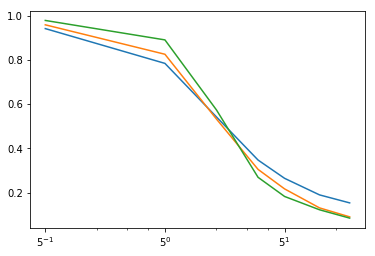

In [65]:
hlist = [.2,1,2,3.5,5,8,12]
temp = t.clock()
f2 = figure2([8,10,12],hlist,[5000,500,50])
print(t.clock()-temp)
out, sub = plt.subplots(1)
sub.semilogx(hlist,f2[0],basex=5)
sub.semilogx(hlist,f2[1],basex=5)
sub.semilogx(hlist,f2[2],basex=5)
#sub.semilogx(hlist,f[3],basex=5)
#sub.semilogx(hlist,f[4],basex=5)
#sub.semilogx(hlist,f[5],basex=5)

In [66]:
Llist = [8,10,12]
temp = t.clock() 
f4 = figure4(Llist,[.5,8],[200,50,10])
print(t.clock()-temp)

L = 8 started.
h = 0.5 finished.
h = 8 finished.
L = 10 started.
h = 0.5 finished.
h = 8 finished.
L = 12 started.
h = 0.5 finished.
h = 8 finished.
8.935045485151932


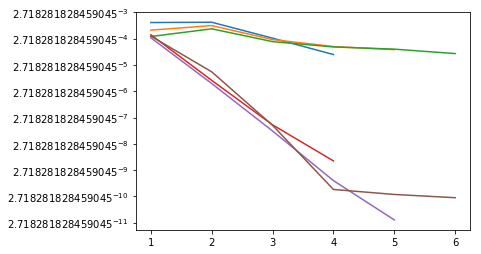

In [68]:
out,sub = plt.subplots(1)
sub.semilogy(np.arange(1,Llist[0]//2+1), np.absolute(np.trim_zeros(f4[0,0],trim='b')), basey = np.e)
sub.semilogy(np.arange(1,Llist[1]//2+1), np.absolute(np.trim_zeros(f4[0,1],trim='b')), basey = np.e)
sub.semilogy(np.arange(1,Llist[2]//2+1), np.absolute(np.trim_zeros(f4[0,2],trim='b')), basey = np.e)
sub.semilogy(np.arange(1,Llist[0]//2+1), np.absolute(np.trim_zeros(f4[1,0],trim='b')), basey = np.e)
sub.semilogy(np.arange(1,Llist[1]//2+1), np.absolute(np.trim_zeros(f4[1,1],trim='b')), basey = np.e)
sub.semilogy(np.arange(1,Llist[2]//2+1), np.absolute(np.trim_zeros(f4[1,2],trim='b')), basey = np.e)

In [69]:
Llist = [8,10,12]
hlist = [2,4.5,6.5,8,10,14,20,26]
dlist = [1000,300,100]
temp = t.clock()
f56 = figure56(Llist,hlist,dlist)
print(t.clock()-temp)

L = 8 started.
h = 2 finished.
h = 4.5 finished.
h = 6.5 finished.
h = 8 finished.
h = 10 finished.
h = 14 finished.
h = 20 finished.
h = 26 finished.
L = 10 started.
h = 2 finished.
h = 4.5 finished.
h = 6.5 finished.
h = 8 finished.
h = 10 finished.
h = 14 finished.


C:\Users\Urrburr\Anaconda3\lib\site-packages\ipykernel_launcher.py:224: RuntimeWarning: divide by zero encountered in log


h = 20 finished.
h = 26 finished.
L = 12 started.
h = 2 finished.
h = 4.5 finished.
h = 6.5 finished.
h = 8 finished.
h = 10 finished.
h = 14 finished.
h = 20 finished.
h = 26 finished.
159.53962291264907


ValueError: range parameter must be finite.

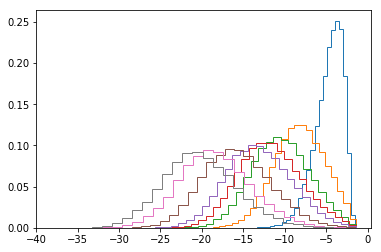

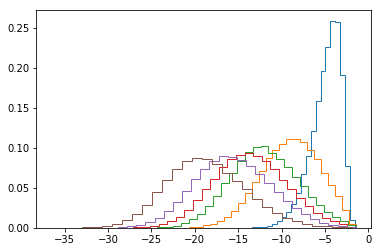

In [70]:
out0,sub0 = plt.subplots(1)
sub0.hist(f56[0][0],density='true',histtype = 'step',bins = 30)
sub0.hist(f56[0][1],density='true',histtype = 'step',bins = 30)
sub0.hist(f56[0][2],density='true',histtype = 'step',bins = 30)
sub0.hist(f56[0][3],density='true',histtype = 'step',bins = 30)
sub0.hist(f56[0][4],density='true',histtype = 'step',bins = 30)
sub0.hist(f56[0][5],density='true',histtype = 'step',bins = 30)
sub0.hist(f56[0][6],density='true',histtype = 'step',bins = 30)
sub0.hist(f56[0][7],density='true',histtype = 'step',bins = 30)
out1,sub1 = plt.subplots(1)
sub1.hist(f56[1][0],density='true',histtype = 'step',bins = 30)
sub1.hist(f56[1][1],density='true',histtype = 'step',bins = 30)
sub1.hist(f56[1][2],density='true',histtype = 'step',bins = 30)
sub1.hist(f56[1][3],density='true',histtype = 'step',bins = 30)
sub1.hist(f56[1][4],density='true',histtype = 'step',bins = 30)
sub1.hist(f56[1][5],density='true',histtype = 'step',bins = 30)
sub1.hist(f56[1][6],density='true',histtype = 'step',bins = 30)
sub1.hist(f56[1][7],density='true',histtype = 'step',bins = 30)
out2,sub2 = plt.subplots(1)
sub2.hist(f56[2][0],density='true',histtype = 'step',bins = 30)
sub2.hist(f56[2][1],density='true',histtype = 'step',bins = 30)
sub2.hist(f56[2][2],density='true',histtype = 'step',bins = 30)
sub2.hist(f56[2][3],density='true',histtype = 'step',bins = 30)
sub2.hist(f56[2][4],density='true',histtype = 'step',bins = 30)
sub2.hist(f56[2][5],density='true',histtype = 'step',bins = 30)
sub2.hist(f56[2][6],density='true',histtype = 'step',bins = 30)
sub2.hist(f56[2][7],density='true',histtype = 'step',bins = 30)

C:\Users\Urrburr\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


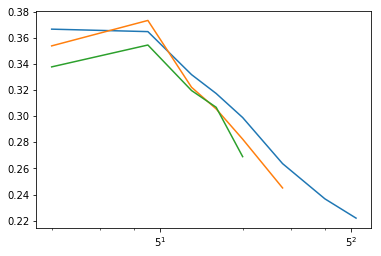

In [71]:
f6 = np.zeros((len(Llist), len(hlist)))
for i in range(len(Llist)):
    for j in range(len(hlist)):
        f6[i,j] = np.std(np.divide(f56[i][j],np.average(f56[i][j])))
out, sub = plt.subplots(1)
sub.semilogx(hlist, f6[0],basex=5)
sub.semilogx(hlist, f6[1],basex=5)
sub.semilogx(hlist, f6[2],basex=5)

In [73]:
hlist = [1,2,3,5,8]
temp = t.clock()
SerbynAbanin1 = BipartEntangleS([8,10,12],hlist,[500,50,5])
print(t.clock()-temp)

L = 8 started.
h = 1 finished.
h = 2 finished.
h = 3 finished.
h = 5 finished.
h = 8 finished.
L = 10 started.
h = 1 finished.
h = 2 finished.
h = 3 finished.
h = 5 finished.
h = 8 finished.
L = 12 started.
h = 1 finished.
h = 2 finished.
h = 3 finished.
h = 5 finished.


C:\Users\Urrburr\Anaconda3\lib\site-packages\ipykernel_launcher.py:288: RuntimeWarning: divide by zero encountered in log


h = 8 finished.
310.26428874453995


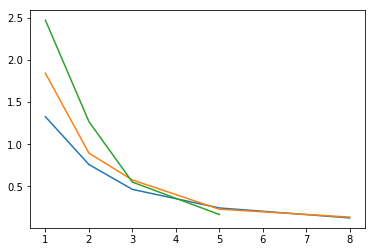

In [74]:
out,sub = plt.subplots(1)
sub.plot(hlist,SerbynAbanin1[0])
sub.plot(hlist,SerbynAbanin1[1])
sub.plot(hlist,SerbynAbanin1[2])
#sub.plot(hlist,SerbynAbanin1[3])

In [75]:
hlist = [1,2,3,5,8]
temp = t.clock()
SerbynAbanin2 = BipartIPR([8,10,12],hlist,[5000,500,50])
print(t.clock()-temp)

L = 8 started.
h = 1 finished.
h = 2 finished.
h = 3 finished.
h = 5 finished.
h = 8 finished.
L = 10 started.
h = 1 finished.
h = 2 finished.
h = 3 finished.
h = 5 finished.
h = 8 finished.
L = 12 started.
h = 1 finished.
h = 2 finished.
h = 3 finished.
h = 5 finished.
h = 8 finished.
77.58870850480162


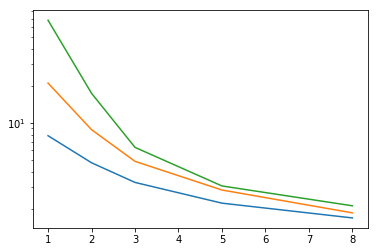

In [76]:
out,sub = plt.subplots(1)
sub.semilogy(hlist,SerbynAbanin2[0],basey=10)
sub.semilogy(hlist,SerbynAbanin2[1],basey=10)
sub.semilogy(hlist,SerbynAbanin2[2],basey=10)
#sub.semilogy(hlist,SerbynAbanin2[3],basey=10)

In [77]:
hlist = [5]
temp = t.clock()
SerbynAbanin3 = BipartEntangleSpectrum([8,10,12,14],hlist,[10000,1000,100,10])
print(t.clock()-temp)

L = 8 started.
h = 5 finished.
L = 10 started.
h = 5 finished.
L = 12 started.
h = 5 finished.
L = 14 started.
h = 5 finished.
760.5789417639608


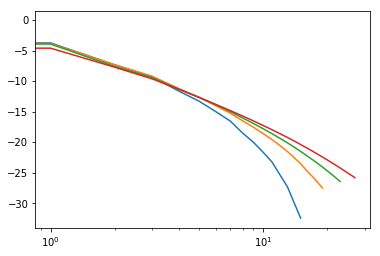

In [78]:
out,sub = plt.subplots(1)
sub.semilogx(np.trim_zeros(SerbynAbanin3[0][0]))
sub.semilogx(np.trim_zeros(SerbynAbanin3[1][0]))
sub.semilogx(np.trim_zeros(SerbynAbanin3[2][0]))
sub.semilogx(np.trim_zeros(SerbynAbanin3[3][0]))

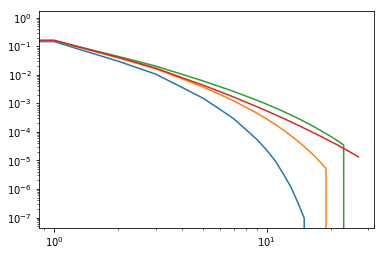

In [48]:
out,sub = plt.subplots(1)
sub.semilogx(np.trim_zeros(SerbynAbanin3[0][1]))
sub.semilogx(np.trim_zeros(SerbynAbanin3[1][1]))
sub.semilogx(np.trim_zeros(SerbynAbanin3[2][1]))
sub.semilogx(np.trim_zeros(SerbynAbanin3[3][1]))

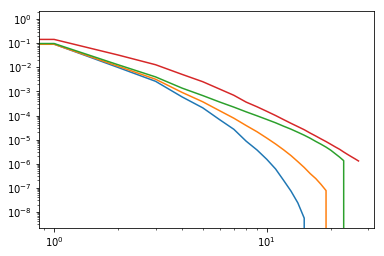

In [47]:
out,sub = plt.subplots(1)
sub.semilogx(np.trim_zeros(SerbynAbanin3[0][2]))
sub.semilogx(np.trim_zeros(SerbynAbanin3[1][2]))
sub.semilogx(np.trim_zeros(SerbynAbanin3[2][2]))
sub.semilogx(np.trim_zeros(SerbynAbanin3[3][2]))

In [95]:
hlist = [2,4,8]
temp = t.clock()
Nandkishore2017 = EntangleDOS([8,10,12,14],hlist,[2000,1000,500,100])
print(t.clock()-temp)

L = 8 started.
h = 2 finished.
h = 4 finished.
h = 8 finished.
L = 10 started.
h = 2 finished.
h = 4 finished.
h = 8 finished.
L = 12 started.
h = 2 finished.
h = 4 finished.
h = 8 finished.
L = 14 started.
h = 2 finished.
h = 4 finished.
h = 8 finished.
18370.879792708205


(array([0.00133768, 0.00222947, 0.00133768, 0.00267537, 0.00445895,
        0.00356716, 0.00312126, 0.00445895, 0.00758021, 0.00802611,
        0.01070148, 0.01605222, 0.02719959, 0.0356716 , 0.03745518,
        0.05038613, 0.06287119, 0.06733014, 0.09230025, 0.10389352,
        0.11860806, 0.13733564, 0.13778154, 0.16230576, 0.14714533,
        0.14759123, 0.15294197, 0.14669944, 0.13109311, 0.13287669,
        0.12975543, 0.12708006, 0.10790658, 0.10746068, 0.09854278,
        0.09274615, 0.07713983, 0.07312677, 0.06599245, 0.06420887,
        0.0530615 , 0.04637307, 0.03745518, 0.03433391, 0.03656339,
        0.0267537 , 0.02184885, 0.00133768, 0.        , 0.00044589]),
 array([-15.82696341, -15.51042414, -15.19388487, -14.8773456 ,
        -14.56080634, -14.24426707, -13.9277278 , -13.61118853,
        -13.29464926, -12.97811   , -12.66157073, -12.34503146,
        -12.02849219, -11.71195292, -11.39541365, -11.07887439,
        -10.76233512, -10.44579585, -10.12925658,  -9.81271731

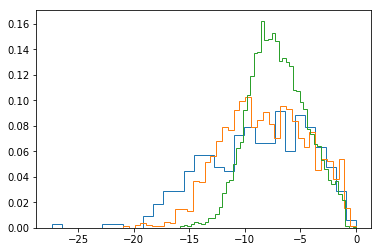

In [90]:
out,sub = plt.subplots(1)
sub.hist(np.array(Nandkishore2017[0][0]), density = True, histtype = 'step', bins = 30)
sub.hist(np.array(Nandkishore2017[1][0]), density = True, histtype = 'step', bins = 40)
sub.hist(np.array(Nandkishore2017[2][0]), density = True, histtype = 'step', bins = 50)

(array([0.00085283, 0.00021321, 0.00127924, 0.        , 0.00085283,
        0.00063962, 0.00063962, 0.0029849 , 0.00447736, 0.00490377,
        0.00660943, 0.0115132 , 0.01535094, 0.01790943, 0.02430565,
        0.03198112, 0.03517923, 0.03880376, 0.04733206, 0.05202262,
        0.05543394, 0.0601245 , 0.06779997, 0.07121129, 0.07078488,
        0.06779997, 0.06673393, 0.06737356, 0.06332261, 0.06225658,
        0.05841884, 0.04839809, 0.04711885, 0.05202262, 0.04477357,
        0.0428547 , 0.03496602, 0.04221508, 0.03326036, 0.02345282,
        0.02835659, 0.0200415 , 0.01449811, 0.01236603, 0.02046792,
        0.01918867, 0.00959434, 0.0057566 , 0.00191887, 0.00021321]),
 array([-33.09998241, -32.43798276, -31.77598311, -31.11398346,
        -30.45198382, -29.78998417, -29.12798452, -28.46598487,
        -27.80398522, -27.14198557, -26.47998593, -25.81798628,
        -25.15598663, -24.49398698, -23.83198733, -23.16998769,
        -22.50798804, -21.84598839, -21.18398874, -20.52198909

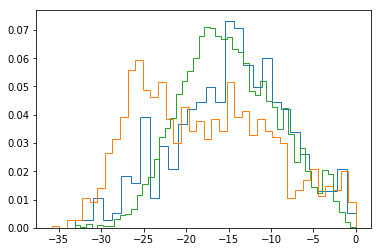

In [94]:
out,sub = plt.subplots(1)
sub.hist(np.array(Nandkishore2017[0][1]), density = True, histtype = 'step', bins = 30)
sub.hist(np.array(Nandkishore2017[1][1]), density = True, histtype = 'step', bins = 40)
sub.hist(np.array(Nandkishore2017[2][1]), density = True, histtype = 'step', bins = 50)

(array([0.00044477, 0.00074128, 0.00118604, 0.00148255, 0.00192732,
        0.00296511, 0.00444766, 0.00845056, 0.01615983, 0.02164528,
        0.03143014, 0.04581091, 0.05352018, 0.05366844, 0.05233414,
        0.04892427, 0.05129635, 0.04699695, 0.0428458 , 0.04625567,
        0.03899116, 0.03409873, 0.03350571, 0.02861328, 0.03009584,
        0.02950282, 0.02950282, 0.02549992, 0.02564818, 0.02194179,
        0.02461039, 0.01956971, 0.01912494, 0.02535167, 0.02238656,
        0.01675286, 0.0109709 , 0.01541856, 0.0096366 , 0.00533719,
        0.00355813, 0.00652324, 0.00444766, 0.00207557, 0.00459592,
        0.00237209, 0.00578196, 0.01408426, 0.006968  , 0.00088953]),
 array([-47.60140334, -46.64937527, -45.69734721, -44.74531914,
        -43.79329107, -42.84126301, -41.88923494, -40.93720687,
        -39.98517881, -39.03315074, -38.08112267, -37.12909461,
        -36.17706654, -35.22503847, -34.27301041, -33.32098234,
        -32.36895427, -31.4169262 , -30.46489814, -29.51287007

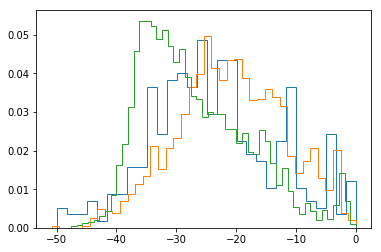

In [93]:
out,sub = plt.subplots(1)
sub.hist(np.array(Nandkishore2017[0][2]), density = True, histtype = 'step', bins = 30)
sub.hist(np.array(Nandkishore2017[1][2]), density = True, histtype = 'step', bins = 40)
sub.hist(np.array(Nandkishore2017[2][2]), density = True, histtype = 'step', bins = 50)